## Toxic Comment Classification

### Introduction ###

As a newcomer to data science, and particularly the domain of transformer models, I've been intrigued by the complexities of BERT. When studying BERT on Kaggle, I noticed that the resources available primarily explain BERT's architecture or offer code snippets with limited descriptions. This project strives to bridge that gap by linking basic BERT theory with practical application using a simple model. The framework of this work is derived from an instructive tutorial found on Kaggle (https://www.kaggle.com/chumajin/pytorch-bert-beginner-s-room), and I've adjusted it to address our specific competition problem. I've also included additional visualizations to trace the model's performance over epochs and different folds.

### Objective ###
The aim is to develop a model that can predict the likelihood of each category of toxicity in any given comment.

This notebook is divided into two parts due to Kaggle's memory restrictions. Each part can function independently. In part I, I explain the basic steps for managing binary classification tasks involving multiple labels. This model operates on a single distribution of the training set and validation set, offering an initial insight into possible performance results (AUC score).

In part II, I've retained necessary code components from part I and demonstrated how we can construct five models using different choices of the training set and validation set, following the k-fold (k=5) method. The toxicity probability for each comment is then calculated as the mean value from these five models.

### Factors Affecting Simulation Time ###
For quick execution of this notebook, both parts I and II allow you to limit the training set to a certain number of rows (200 in part I and 2000 in part II). The limitation in part I is due to its instructional nature, which necessitates the inclusion of several variables and can lead to a CUDA memory crash for larger row numbers, yielding moderate results for part I (accuracy: 86%).

Part II is more streamlined, allowing an increase in the number of rows potentially up to the complete training set. However, it's capped at 2000 rows to deliver reasonably good results (94% accuracy and 0.988 AUC score) within a 22-minute simulation.

To observe improvements in accuracy and losses across different epochs, you can adjust parameters to (epochs = 5, k = 5). This notebook doesn't aim for the highest results, but rather a satisfactory level of performance.

## PART I
## 1. Prepare the data
### a. Loading libraries

In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

We set a seed for reproducability of the results.

In [2]:
SEED = 34

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [3]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip', nrows = 200 )
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
temp = train[train['toxic'] == 1]
temp.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [5]:
print(len(train['comment_text'][10]), 'Total Characters')
train['comment_text'][10]

2875 Total Characters


'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

A comment can be toxic, severe_toxic, obscene and insult at the same time. So the class for each comment is not limited to one.
<br>Now let's check the values for each column in train dataset.

In [6]:
labels = train.drop(['id', 'comment_text'], axis = 1)
unique_values = lambda x: train[x].unique()
[unique_values(col) for col in labels.columns.tolist()]

[array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1])]

In [7]:
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', nrows = 100)
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip', nrows = 10)
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [9]:
submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip', nrows = 10)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


## 2. Summerize data
### a. Descriptive statistics
### Missing values

In [10]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [11]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

Great! we have no missing value!
### Distribution of each class in the train set and test labels
Let's check how many of each category is found in our training data:

In [12]:
df_train = train.drop(['id', 'comment_text'], axis = 1)
label_counts = df_train.sum()
df_counts = pd.DataFrame(label_counts)
df_counts.rename(columns = {0:'counts'}, inplace = True)
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts 

,counts
toxic,20
insult,12
obscene,11
severe_toxic,3
identity_hate,3
threat,2


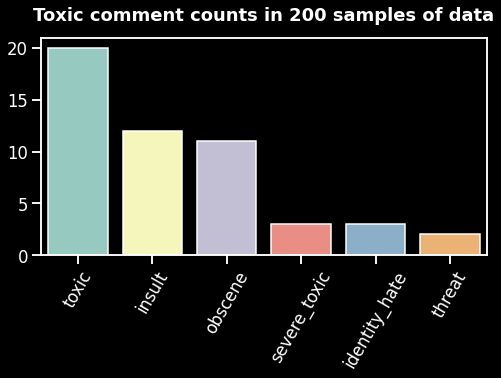

In [13]:
fig, ax = plt.subplots(figsize = (8,4))
p = sns.barplot(df_counts.index, df_counts['counts'])
x = plt.xticks(rotation = 60) 
ax.set_title('Toxic comment counts in '+ str(len(df_train))+ ' samples of data', weight = 'bold', fontsize = 18, y = 1.05)
x = ax.set_ylabel('')

Relative percentage gives us a better understanding.

In [14]:
labels = np.round(df_train.sum()/len(df_train)*100, 1)
labels

toxic            10.0
severe_toxic      1.5
obscene           5.5
threat            1.0
insult            6.0
identity_hate     1.5
dtype: float64

In [15]:
df_test_labels = test_labels.drop(['id'], axis = 1)
count_values = lambda x: np.round(df_test_labels[x].value_counts(normalize = True)*100, 1)
pd.DataFrame([count_values(col) for col in df_test_labels.columns.tolist()])

,-1,0
toxic,80.0,20.0
severe_toxic,80.0,20.0
obscene,80.0,20.0
threat,80.0,20.0
insult,80.0,20.0
identity_hate,80.0,20.0


In [16]:
train.shape, test.shape

((200, 8), (100, 2))

## 3. Prepare Data
### a. Data cleaning 
We need to clean, tokenize and convert the data to tensors. <br>
The function below helps us with:

- Removing hyperlinks, punctuation and numbers
- Tokenizeation

We skip changing it all to lower case and keep the letters sensetive to case. The comment BAD!! has stronger negative emotion in it than bad!! <br>
We also do not remove the stop words, Since with contextual models such as BERT and ROBERTA it is (almost) always better not to process the texts removing stopwords. These models are pretrained with stopwords: if you remove stop words your model may lose the context. This is also true for stemming and lemmatization preprocessing techniques. So we skip them too!

In [18]:
# text preprocessing helper functions [1]

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    #text = text.lower()
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = <, zero or more characters, >, (one or more occurance of >)
    text = re.sub('<.*?>+', '', text)
    
    #pattern = any punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #pattern = any new line
    text = re.sub('\n', '', text)
    
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)
    return text

In [19]:
%%time
train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

CPU times: user 39.6 ms, sys: 1.09 ms, total: 40.7 ms
Wall time: 39.8 ms


### b. Dataset and Dataloader
We use 20% of the training data as validation set.

In [20]:
kfold = 5
train['kfold'] = train.index % kfold
train.index % kfold

Int64Index([0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
            ...
            0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
           dtype='int64', length=200)

In [21]:
#reset_index creates a column with the name of 'index' and saves the old index values in it and updates the values of index.
#drop = True removes the column 'index' with the old index values. 
p_train = train[train["kfold"] != 0].reset_index(drop = True)
p_valid = train[train["kfold"] == 0].reset_index(drop = True)

In [22]:
p_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,kfold
0,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww He matches this background colour Im seem...,1
1,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...,2
2,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,MoreI cant make any real suggestions on improv...,3
3,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,4
4,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1


In [23]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [24]:
%%time
senten_len = []
for sentence in tqdm(p_train['clean_text']):
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    senten_len.append(len(token_words))

100%|██████████| 160/160 [00:00<00:00, 530.00it/s]

CPU times: user 302 ms, sys: 4.9 ms, total: 307 ms
Wall time: 307 ms


We'll have a look at the distribution of the length for tokenized comments to have an intuation about what to set as max_length for our tokenized comments.

Text(0.5, 0, 'Tocken count')

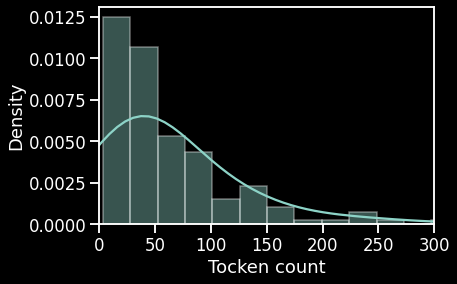

In [25]:
sns.distplot(senten_len)
plt.xlim([0, 300])
plt.xlabel('Tocken count')

It seems that 200 is good size move on with. 

In [26]:
max_len = 200

We define a class BertDataSet with Dataset as super class and overwirte the__init_, __ len__ and __ getitem__ function in it. It will get the comment list and relevant toxic labels (6 labels in this case) and creates token ids and attention mask to distinguish the comments from the zero padding.

**torch.tensor vs np.ndarray:** <br>
If you are only interested in efficient and easy way to perform mathematical operations on matrices np.ndarray or torch.tensor can be used interchangeably.

However, torch.tensors are designed to be used in the context of gradient descent optimization, and therefore they hold not only a tensor with numeric values, but (and more importantly) the computational graph leading to these values. This computational graph is then used (using the chain rule of derivatives) to compute the derivative of the loss function w.r.t each of the independent variables used to compute the loss.

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.

In [27]:
class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

In [28]:
train_dataset = BertDataSet(p_train['clean_text'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
valid_dataset = BertDataSet(p_valid['clean_text'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

Let's have a look what's inside a dataset:

In [29]:
for a in train_dataset:
    print(a)
    break

{'ids': tensor([  101, 10136,  2246,  2246,  1124,  2697,  1142,  3582,  5922,   146,
         1306,  9321,  5342,  1114,  5749,  2037,  1356, 11390,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,

Now we set the batch-size for trainig set and validation set. The bigger batch size helps to speed up the computations. However, the results confirm that using small batch sizes achieves the best generalization performance, for a given computation cost. In all cases, the best results have been obtained with batch sizes of 32 or smaller. Often mini-batch sizes as small as 2 or 4 deliver optimal results.

In [30]:
train_batch = 32
valid_batch = 32

In the code below pin_memory = True to a DataLoader will automatically put the fetched data Tensors in pinned memory, 
and thus enables faster data transfer to CUDA-enabled GPUs. This is best explained in the [NVIDIA blogpost](https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/). I will borrow the picture from it. 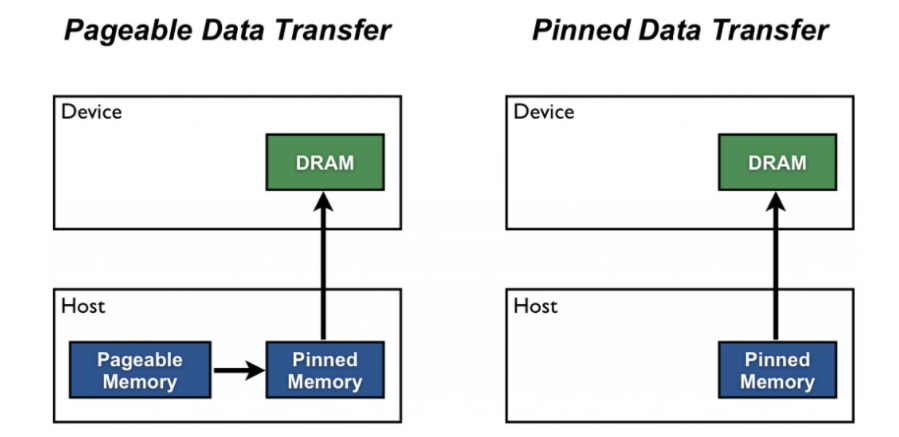<br>
num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processesm

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 4, shuffle = False)

Here we can check inside the dataloader:

In [32]:
%%time
for a in train_dataloader:
    print(a)
    print('id shape in data laoder is',a['ids'].shape)
    break

{'ids': tensor([[  101,   146,  1306,  ...,     0,     0,     0],
        [  101, 23330,  1252,  ...,     0,     0,     0],
        [  101,  6003,  2249,  ...,     0,     0,     0],
        ...,
        [  101,   146,  1274,  ...,     0,     0,     0],
        [  101,  2048,  1157,  ...,     0,     0,     0],
        [  101,  1622,  1184,  ...,     0,     0,     0]]), 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'toxic_label': tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0.],
        [0., 

## 4. BERT Modeling
For faster computation, let's set the device cuda if it is available.

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
%%time
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6)
model.to(device)
model.train()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

CPU times: user 11.1 s, sys: 1.52 s, total: 12.6 s
Wall time: 18.5 s


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

The model makes use of id and mask from token encoding in the trian set. At this state, there is no need to feed in the model with the target values such as toxic, obscene, etc.

In [35]:
%%time
for a in train_dataloader:
    ids = a['ids'].to(device)
    mask = a['mask'].to(device)
    output = model(ids, mask)
    break

CPU times: user 273 ms, sys: 338 ms, total: 611 ms
Wall time: 1.49 s


In [36]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-0.3542, -0.1428,  0.3837,  0.1398,  0.0072, -0.4238],
        [-0.5460,  0.0210,  0.4857,  0.0827,  0.3153, -0.5338],
        [-0.8783,  0.3682,  0.3032, -0.0032,  0.1506, -0.6369],
        [-0.4888,  0.3051,  0.5382,  0.0938,  0.0704, -0.7618],
        [-0.2970,  0.2151,  0.7502,  0.0988, -0.2166, -0.4303],
        [-0.7671,  0.0233,  0.4090,  0.2848,  0.4367, -0.7269],
        [-0.7926,  0.1802,  0.3457,  0.0997,  0.1087, -0.8157],
        [-0.6025,  0.2784,  0.3390,  0.0451,  0.0264, -0.3782],
        [-0.6003,  0.4002,  0.6117,  0.1533,  0.3996, -0.6843],
        [-0.2051,  0.0857,  0.5420,  0.2893,  0.2003, -0.5989],
        [-1.0728,  0.3154,  0.2007,  0.1987,  0.1270, -0.6331],
        [-0.7741,  0.1425,  0.2046,  0.2261,  0.1219, -0.7199],
        [-0.6812,  0.3636,  0.5251,  0.3224,  0.4358, -0.7698],
        [-0.5970,  0.2188,  0.3277,  0.4231,  0.3917, -0.7629],
        [-0.6799,  0.3366,  0.4109, -0.0134,  0.3242, -0.7981

To get the output probabilities, we should use sigmoid function. This can be done either in the model or like here be applied to the output from model. I was first making the mistake and used softmax function. However, in our case a comment can be classified as toxic, obscene and insult at the same time. Hence it's not a multi-classficationm and therefore, this is not applicable. <br>
Here is the summary of differences between softmax function and sigmoid funciton. <br>

**Softmax funciton:**<br>
- Used for Multi-classification in the Logistics Regression model
- The probabilities sum will be 1<br>

**Sigmoid funciton:**
- Used for Binary Classification in the Logistic Regression model
- The probabilities sum does not need to be 1

To learn more about them you can read this: https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322

In [37]:
func.softmax(output['logits'], dim = 1)

tensor([[0.1200, 0.1482, 0.2510, 0.1967, 0.1722, 0.1119],
        [0.0924, 0.1629, 0.2593, 0.1733, 0.2187, 0.0935],
        [0.0704, 0.2448, 0.2294, 0.1689, 0.1969, 0.0896],
        [0.0970, 0.2146, 0.2710, 0.1738, 0.1697, 0.0739],
        [0.1116, 0.1862, 0.3179, 0.1657, 0.1209, 0.0976],
        [0.0731, 0.1611, 0.2369, 0.2093, 0.2436, 0.0761],
        [0.0791, 0.2092, 0.2468, 0.1930, 0.1947, 0.0773],
        [0.0908, 0.2191, 0.2328, 0.1735, 0.1703, 0.1136],
        [0.0779, 0.2118, 0.2617, 0.1654, 0.2116, 0.0716],
        [0.1210, 0.1619, 0.2555, 0.1984, 0.1815, 0.0816],
        [0.0588, 0.2355, 0.2100, 0.2095, 0.1950, 0.0912],
        [0.0807, 0.2019, 0.2148, 0.2195, 0.1978, 0.0852],
        [0.0720, 0.2048, 0.2407, 0.1965, 0.2201, 0.0659],
        [0.0827, 0.1870, 0.2085, 0.2294, 0.2223, 0.0701],
        [0.0813, 0.2246, 0.2419, 0.1583, 0.2218, 0.0722],
        [0.0712, 0.2217, 0.1937, 0.1866, 0.2536, 0.0732],
        [0.0853, 0.1720, 0.2387, 0.2208, 0.2232, 0.0601],
        [0.046

In [38]:
output_probs = func.softmax(output['logits'], dim = 1)

In [39]:
torch.max(output_probs, dim = 1)

torch.return_types.max(
values=tensor([0.2510, 0.2593, 0.2448, 0.2710, 0.3179, 0.2436, 0.2468, 0.2328, 0.2617,
        0.2555, 0.2355, 0.2195, 0.2407, 0.2294, 0.2419, 0.2536, 0.2387, 0.2498,
        0.2640, 0.3014, 0.2250, 0.2705, 0.3428, 0.3027, 0.2513, 0.2206, 0.2363,
        0.2993, 0.2658, 0.2539, 0.2829, 0.2887], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([2, 2, 1, 2, 2, 4, 2, 2, 2, 2, 1, 3, 2, 3, 2, 4, 2, 1, 2, 2, 2, 2, 2, 1,
        4, 2, 4, 2, 1, 2, 2, 2], device='cuda:0'))

## 5. Functions for training and validating
### a. Setting up some parameters

In [40]:
epochs = 5
LR = 2e-5 #Learning rate
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2, correct_bias = False)

We use the learning rate parameter as set above for 10% of total training time. We then decrease the learning rate gradualy to zero. 

In [41]:
train_steps = int((len(train) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


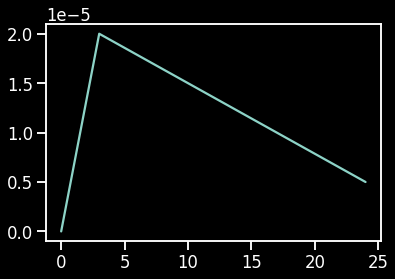

In [42]:
le = []
for b in tqdm(range(epochs)):
    for a in train_dataloader:
        le.append(scheduler.get_last_lr())
        scheduler.step()
plt.plot(np.arange(len(le)), le)

In [43]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)

BCEWithLogitsLoss()

In [44]:
scaler = torch.cuda.amp.GradScaler()

### b. Training function
You can find more details about some keywords in this block of code below it.

In [45]:
def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_train)*6)
    
    return losses, accuracy

**amp** stands for automatic mixed precision. <br>
To learn more about the **autocast** read this link: <br>
https://pytorch.org/docs/stable/amp.html <br>
in short: Instances of autocast serve as context managers or decorators that allow regions of your script to run in mixed precision, where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
autocast should wrap only the forward pass(es) of your network, including the loss computation(s). Backward passes under autocast are not recommended. <br>
<br>
**with** statement in Python is used in exception handling to make the code cleaner and much more readable. It simplifies the management of common resources like file streams. Here is a link to learn more about it.<br>
https://www.geeksforgeeks.org/with-statement-in-python/<br>

**Non-Blocking** allows you to overlap compute and memory transfer to the GPU. Pinned Memory allows the non-blocking calls to actually be non-blocking.<br>

Why using **var.detach().cpu().numpy()** and not var.numpy() only? <br>
because we get an error. The main reason behind this choice presumably is to avoid confusing new comers. People not very familiar with requires_grad and cpu/gpu Tensors might go back and forth with numpy. For example doing pytorch -> numpy -> pytorch and backward on the last Tensor. This will backward without issue but not all the way to the first part of the code and won’t raise any error.
So the choice has been made to force the user to detach() to make sure they want to do it and it’s not a typo/other library that does this tranformation and breaks the computational graph.<br>

**optimizer.step():** it performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule. As an example, the update rule for SGD is defined here:<br>
https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63 <br>

**loss.backward()** Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. This is why you should call optimizer.zero_grad() after each .step() call. Note that following the first .backward call, a second call is only possible after you have performed another forward pass.

### Gradient Scaling
If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients. Gradient values with small magnitudes may not be representable in float16. These values will flush to zero (“underflow”), so the update for the corresponding parameters will be lost.<br>

To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes a backward pass on the scaled loss(es). Gradients flowing backward through the network are then scaled by the same factor. In other words, gradient values have a larger magnitude, so they don’t flush to zero.<br>

Each parameter’s gradient (.grad attribute) should be unscaled before the optimizer updates the parameters, so the scale factor does not interfere with the learning rate.<br>

**step()** carries out the following two operations:
1. Internally invokes unscale_(optimizer) (unless unscale_() was explicitly called for optimizer earlier in the iteration). As part of the unscale_(), gradients are checked for infs/NaNs.
2. If no inf/NaN gradients are found, invokes optimizer.step() using the unscaled gradients. Otherwise, optimizer.step() is skipped to avoid corrupting the params.

### c. Validating function
validating function is quite similar to training function. The difference is that there is no back-propagation and optemization for parameters in it. 

In [46]:
def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

## 6. Training the model
### a. Run training function

In [47]:
%%time

best_score = 1000
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for eboch in tqdm(range(epochs)):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    
    if valid_loss < best_score:
        best_score = valid_loss
        print('Found a good model!')
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(state, 'best_model.pth')
    else:
        pass

  0%|          | 0/5 [00:00<?, ?it/s]

train losses: 0.6391 train accuracy: 0.535
valid losses: 0.6056 valid accuracy: 0.846
Found a good model!


 20%|██        | 1/5 [00:07<00:28,  7.08s/it]

train losses: 0.6102 train accuracy: 0.794
valid losses: 0.6003 valid accuracy: 0.863
Found a good model!


 60%|██████    | 3/5 [00:20<00:12,  6.41s/it]

train losses: 0.6156 train accuracy: 0.778
valid losses: 0.6003 valid accuracy: 0.863


 80%|████████  | 4/5 [00:24<00:05,  5.63s/it]

train losses: 0.6144 train accuracy: 0.792
valid losses: 0.6003 valid accuracy: 0.863


100%|██████████| 5/5 [00:29<00:00,  5.81s/it]

train losses: 0.6172 train accuracy: 0.770
valid losses: 0.6003 valid accuracy: 0.863
CPU times: user 20.3 s, sys: 4.4 s, total: 24.7 s
Wall time: 29.1 s


### b. Plotting the results

Text(0.5, 0.98, 'Fold = 0')

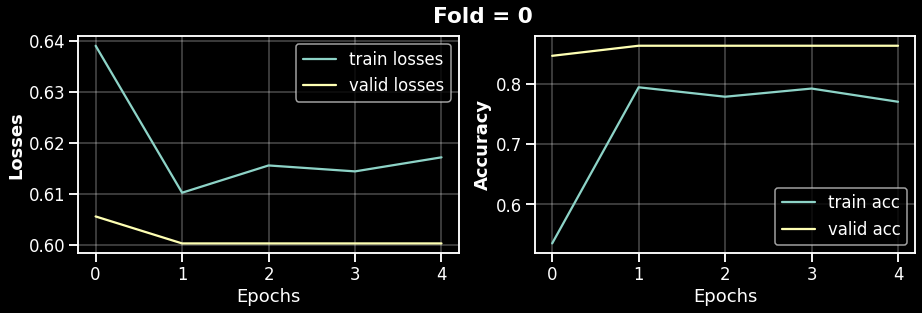

In [48]:
x = np.arange(epochs)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Fold = 0', weight = 'bold') 


## 7. Evaluation
We use auc as a metric of evaluation in this report.

In [53]:
valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
valid_probs = np.asarray(valid_probs).flatten()
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()
fpr, tpr, _ = roc_curve(y_valid, valid_probs)

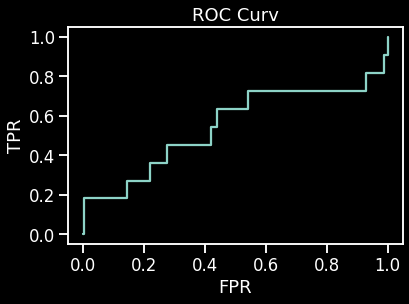

In [54]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

In [55]:
auc(fpr, tpr)

0.5486304088924175

## PART II

You can start to run the notebook from here until the end. I have copied all the necessary parts from part I in this notebook. The objective here is to show how the model works for 5 different folds. epochs is set to 5 and the first 2000 rows of the trianing set is used. Feel free to change these parameters and see how it affects the accuracy.

In [56]:
%%time
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip', nrows = 2000)
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', nrows = 100)
submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')

SEED = 34
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
random_seed(SEED)

def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

kfold = 5
train['kfold'] = train.index % kfold

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
max_len = 200

class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

epochs = 5
train_batch = 15
valid_batch = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)
scaler = torch.cuda.amp.GradScaler()

def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_train)*6)
    
    return losses, accuracy

def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

CPU times: user 579 ms, sys: 40.3 ms, total: 619 ms
Wall time: 2.51 s


## 8. Repeat training for k-fold

To improve our model we repeat the same process of training for each fold of k-folds.

  0%|          | 0/5 [00:00<?, ?it/s]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

-------------- Fold = 0-------------
-------------- Epoch = 0-------------
train losses: 0.0787 train accuracy: 0.815
valid losses: 0.1308 valid accuracy: 0.973
Found an improved model! :)



 20%|██        | 1/5 [00:43<02:53, 43.34s/it]

-------------- Epoch = 1-------------



 40%|████      | 2/5 [01:25<02:07, 42.60s/it]

train losses: 0.0558 train accuracy: 0.974
valid losses: 0.1393 valid accuracy: 0.977
-------------- Epoch = 2-------------



 60%|██████    | 3/5 [02:06<01:23, 41.76s/it]

train losses: 0.0289 train accuracy: 0.981
valid losses: 0.1609 valid accuracy: 0.975
-------------- Epoch = 3-------------



 80%|████████  | 4/5 [02:46<00:41, 41.27s/it]

train losses: 0.1544 train accuracy: 0.985
valid losses: 0.1537 valid accuracy: 0.978
-------------- Epoch = 4-------------



100%|██████████| 5/5 [03:27<00:00, 41.46s/it]

train losses: 0.0322 train accuracy: 0.986
valid losses: 0.1536 valid accuracy: 0.977



 20%|██        | 1/5 [03:34<14:16, 214.06s/it]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

-------------- Fold = 1-------------
-------------- Epoch = 0-------------
train losses: 0.1070 train accuracy: 0.824
valid losses: 0.2327 valid accuracy: 0.955
Found an improved model! :)



 20%|██        | 1/5 [00:44<02:56, 44.23s/it]

-------------- Epoch = 1-------------
train losses: 0.0397 train accuracy: 0.964
valid losses: 0.1432 valid accuracy: 0.956
Found an improved model! :)



 40%|████      | 2/5 [01:29<02:14, 44.84s/it]

-------------- Epoch = 2-------------



 60%|██████    | 3/5 [02:10<01:26, 43.03s/it]

train losses: 0.0181 train accuracy: 0.975
valid losses: 0.2080 valid accuracy: 0.975
-------------- Epoch = 3-------------



 80%|████████  | 4/5 [02:51<00:42, 42.13s/it]

train losses: 0.0609 train accuracy: 0.984
valid losses: 0.1535 valid accuracy: 0.977
-------------- Epoch = 4-------------



100%|██████████| 5/5 [03:31<00:00, 42.35s/it]

train losses: 0.1605 train accuracy: 0.987
valid losses: 0.2059 valid accuracy: 0.977



 40%|████      | 2/5 [07:07<10:41, 213.71s/it]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

-------------- Fold = 2-------------
-------------- Epoch = 0-------------
train losses: 0.1611 train accuracy: 0.808
valid losses: 0.1088 valid accuracy: 0.961
Found an improved model! :)



 20%|██        | 1/5 [00:44<02:56, 44.19s/it]

-------------- Epoch = 1-------------
train losses: 0.1345 train accuracy: 0.971
valid losses: 0.0329 valid accuracy: 0.973
Found an improved model! :)



 40%|████      | 2/5 [01:28<02:13, 44.49s/it]

-------------- Epoch = 2-------------
train losses: 0.1401 train accuracy: 0.979
valid losses: 0.0200 valid accuracy: 0.975
Found an improved model! :)



 60%|██████    | 3/5 [02:12<01:28, 44.17s/it]

-------------- Epoch = 3-------------
train losses: 0.0193 train accuracy: 0.983
valid losses: 0.0161 valid accuracy: 0.975
Found an improved model! :)



 80%|████████  | 4/5 [02:56<00:44, 44.12s/it]

-------------- Epoch = 4-------------
train losses: 0.0165 train accuracy: 0.987
valid losses: 0.0157 valid accuracy: 0.975
Found an improved model! :)



 60%|██████    | 3/5 [10:49<07:15, 217.65s/it]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

-------------- Fold = 3-------------
-------------- Epoch = 0-------------
train losses: 0.2050 train accuracy: 0.878
valid losses: 0.0627 valid accuracy: 0.968
Found an improved model! :)



 20%|██        | 1/5 [00:43<02:55, 43.87s/it]

-------------- Epoch = 1-------------
train losses: 0.0313 train accuracy: 0.961
valid losses: 0.0525 valid accuracy: 0.970
Found an improved model! :)



 40%|████      | 2/5 [01:28<02:13, 44.42s/it]

-------------- Epoch = 2-------------
train losses: 0.0742 train accuracy: 0.965
valid losses: 0.0223 valid accuracy: 0.974
Found an improved model! :)



 60%|██████    | 3/5 [02:13<01:28, 44.44s/it]

-------------- Epoch = 3-------------



 80%|████████  | 4/5 [02:54<00:43, 43.06s/it]

train losses: 0.0170 train accuracy: 0.974
valid losses: 0.0304 valid accuracy: 0.979
-------------- Epoch = 4-------------
train losses: 0.0633 train accuracy: 0.978
valid losses: 0.0220 valid accuracy: 0.980
Found an improved model! :)



 80%|████████  | 4/5 [14:32<03:39, 219.78s/it]Some weights of the model checkpoint at ../input/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

-------------- Fold = 4-------------
-------------- Epoch = 0-------------
train losses: 0.1014 train accuracy: 0.842
valid losses: 0.0562 valid accuracy: 0.965
Found an improved model! :)



 20%|██        | 1/5 [00:43<02:54, 43.56s/it]

-------------- Epoch = 1-------------
train losses: 0.1046 train accuracy: 0.972
valid losses: 0.0417 valid accuracy: 0.976
Found an improved model! :)



 40%|████      | 2/5 [01:28<02:12, 44.19s/it]

-------------- Epoch = 2-------------



 60%|██████    | 3/5 [02:08<01:25, 42.56s/it]

train losses: 0.0699 train accuracy: 0.981
valid losses: 0.0472 valid accuracy: 0.975
-------------- Epoch = 3-------------
train losses: 0.0168 train accuracy: 0.985
valid losses: 0.0328 valid accuracy: 0.979
Found an improved model! :)



 80%|████████  | 4/5 [02:53<00:43, 43.37s/it]

-------------- Epoch = 4-------------
train losses: 0.0592 train accuracy: 0.988
valid losses: 0.0276 valid accuracy: 0.978
Found an improved model! :)



100%|██████████| 5/5 [18:11<00:00, 218.40s/it]


CPU times: user 16min 49s, sys: 41 s, total: 17min 30s
Wall time: 18min 12s


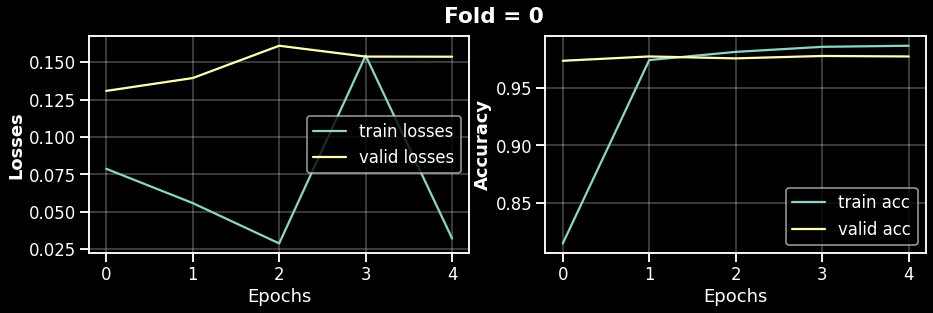

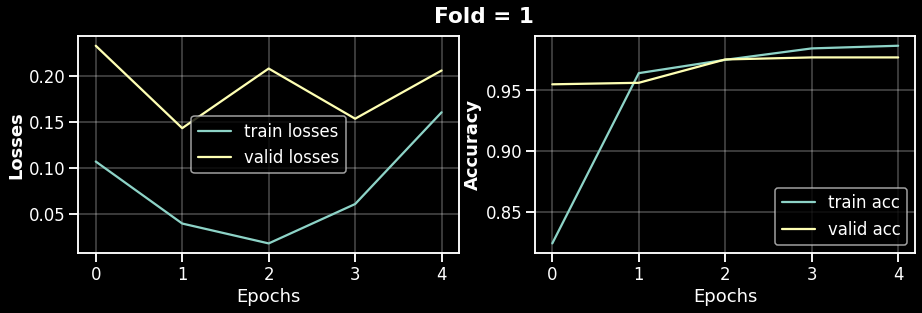

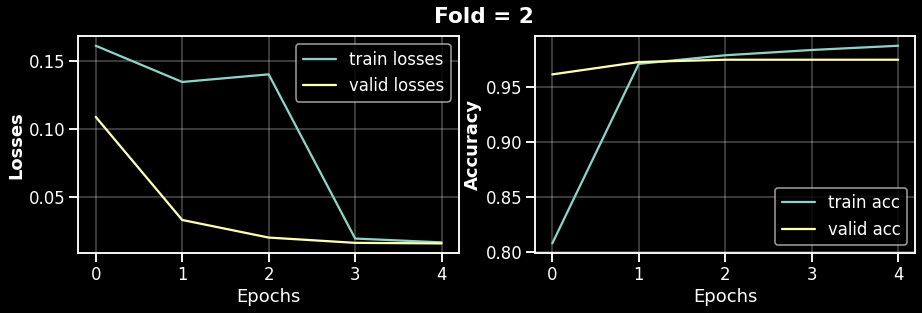

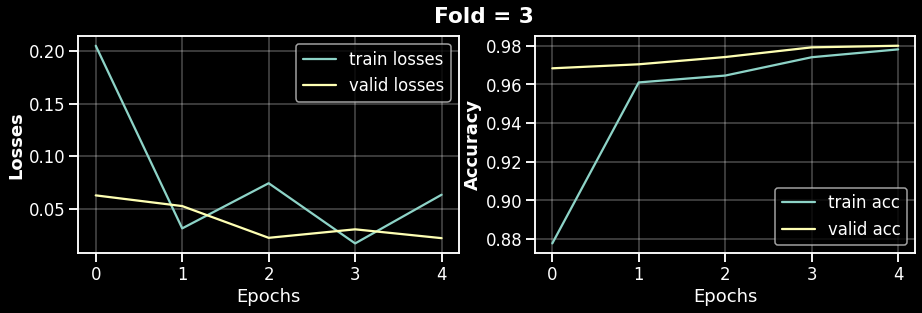

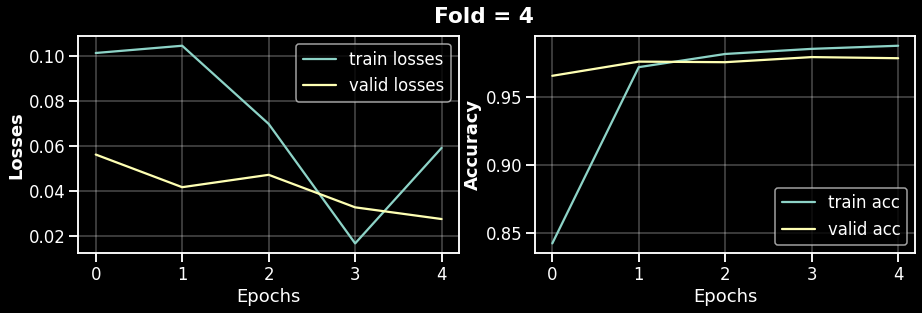

In [62]:
%%time

best_scores = []
for fold in tqdm(range(0,5)):

    # initializing the data
    p_train = train[train['kfold'] != fold].reset_index(drop = True)
    p_valid = train[train['kfold'] == fold].reset_index(drop = True)

    train_dataset = BertDataSet(p_train['clean_text'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
    valid_dataset = BertDataSet(p_valid['clean_text'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 4, pin_memory = True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, shuffle = False, num_workers = 4, pin_memory = True)

    model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-cased", num_labels = 6)
    model.to(device)
    
    LR = 2e-5
    optimizer = AdamW(model.parameters(), LR,betas = (0.9, 0.999), weight_decay = 1e-2) # AdamW optimizer

    train_steps = int(len(p_train)/train_batch * epochs)
    num_steps = int(train_steps * 0.1)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
    
    best_score = 1000
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    best_valid_probs = []
    
    print("-------------- Fold = " + str(fold) + "-------------")
    
    for epoch in tqdm(range(epochs)):
        print("-------------- Epoch = " + str(epoch) + "-------------")

        train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
        valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        print('train losses: %.4f' %(train_loss), 'train accuracy: %.3f' %(train_acc))
        print('valid losses: %.4f' %(valid_loss), 'valid accuracy: %.3f' %(valid_acc))

        if (valid_loss < best_score):

            best_score = valid_loss
            print("Found an improved model! :)")

            state = {'state_dict': model.state_dict(),
                     'optimizer_dict': optimizer.state_dict(),
                     'best_score':best_score
                    }

            torch.save(state, "model" + str(fold) + ".pth")
            best_valid_prob = valid_probs
            torch.cuda.memory_summary(device = None, abbreviated = False)
        else:
            pass
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()

    best_scores.append(best_score)
    best_valid_probs.append(best_valid_prob)
    
    ##Plotting the result for each fold
    x = np.arange(epochs)
    fig, ax = plt.subplots(1, 2, figsize = (15,4))
    ax[0].plot(x, train_losses)
    ax[0].plot(x, valid_losses)
    ax[0].set_ylabel('Losses', weight = 'bold')
    ax[0].set_xlabel('Epochs')
    ax[0].grid(alpha = 0.3)
    ax[0].legend(labels = ['train losses', 'valid losses'])

    ax[1].plot(x, train_accs)
    ax[1].plot(x, valid_accs)
    ax[1].set_ylabel('Accuracy', weight = 'bold')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(labels = ['train acc', 'valid acc'])

    ax[1].grid(alpha = 0.3)
    fig.suptitle('Fold = '+str(fold), weight = 'bold') 

In [63]:

torch.cuda.empty_cache()


In [64]:
best_scores

[0.13075479865074158,
 0.14324812591075897,
 0.015689300373196602,
 0.022001368924975395,
 0.0275884922593832]

In [65]:
print('Mean of',kfold, 'folds for best loss in', epochs, 'epochs cross-validation folds is %.4f.' %(np.mean(best_scores)))

Mean of 5 folds for best loss in 5 epochs cross-validation folds is 0.0679.


## 9. Evaluation for k-models

We use ensemble for evaluating k-models in the validation set.

In [66]:
def predicting(test_dataloader, model, pthes):
    allpreds = []
    
    for pth in pthes:
        state = torch.load(pth)
        model.load_state_dict(state['state_dict'])
        model.to(device)
        model.eval()
        preds = []
        with torch.no_grad():
            for a in test_dataloader:
                ids = a['ids'].to(device)
                mask = a['mask'].to(device)
                output = model(ids, mask)
                output = output['logits'].squeeze(-1)
                output_probs = torch.sigmoid(output)
                preds.append(output_probs.cpu().numpy())
            preds = np.concatenate(preds)
            allpreds.append(preds)
      
    return allpreds

In [67]:
pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]

In [68]:
allpreds = predicting(valid_dataloader, model, pthes)

Taking the avarage of probabilities from k-models for each sample in the validation set.

In [69]:
valid_probs = np.zeros((len(p_valid),6))
for i in range(kfold):
    valid_probs += allpreds[i]
valid_probs = valid_probs / kfold

In [70]:
valid_probs = np.asarray(valid_probs).flatten()

In [71]:
#valid_probs = allpreds[0].flatten() #This line is used when trianing for one model and not k-fold model 
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()

In [72]:
fpr, tpr, _ = roc_curve(y_valid, valid_probs)
print('auc score for kfold =', kfold, 'models is: %.2f' %(auc(fpr, tpr)*100))

auc score for kfold = 5 models is: 99.19


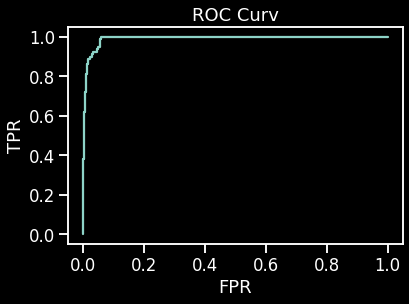

In [73]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

## 10. Inference

In [74]:
class BERTinferenceDataSet(Dataset):
    
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_sent = tokenizer.encode_plus(sentence, 
                                         add_special_tokens = True, #[SEP][PAD]
                                         max_length = max_len,
                                         pad_to_max_length = True,
                                         truncation = True)

        ids = torch.tensor(bert_sent['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_sent['attention_mask'], dtype = torch.long)

        return{
            'ids' : ids,
            'mask' : mask
             }

In [75]:
test_batch = 32
test_dataset = BERTinferenceDataSet(test['clean_text'])
test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers = 4, pin_memory = True)
pthes = [os.path.join("../input/bert-model-for-dummies",s) for s in os.listdir('../input/bert-model-for-dummies') if ".pth" in s]
pthes


['../input/bert-model-for-dummies/model1.pth',
 '../input/bert-model-for-dummies/model2.pth',
 '../input/bert-model-for-dummies/model4.pth',
 '../input/bert-model-for-dummies/model3.pth',
 '../input/bert-model-for-dummies/model0.pth']

In [76]:
allpreds = predicting(test_dataloader, model, pthes)

In [77]:
print('allpreds is an array with the shape of:',len(allpreds), 'x',len(allpreds[0]), 'x',len(allpreds[0][0]))
allpreds[0][0]

allpreds is an array with the shape of: 5 x 100 x 6


array([0.4601297 , 0.30013636, 0.4116267 , 0.17326939, 0.4308261 ,
       0.22566721], dtype=float32)

We take the average of the probabilities in 5 folds.

In [78]:
preds = np.zeros((len(test_dataset),6))
for i in range(kfold):
    preds += allpreds[i]
preds = preds / kfold

In [79]:
results = pd.DataFrame(preds)
subs = pd.concat([test,results], axis = 1)
subs.rename(columns = { 0:'toxic', 1:'severe_toxic', 2:'obscene', 3:'threat', 4:'insult', 5:'identity_hate'}, inplace = True)
submission = pd.concat([test,results], axis = 1).drop(['comment_text', 'clean_text'], axis = 1)
submission.rename(columns = { 0:'toxic', 1:'severe_toxic', 2:'obscene', 3:'threat', 4:'insult', 5:'identity_hate'}, inplace = True)
submission.to_csv("submission.csv", index = False)

In [80]:
subs

,id,comment_text,clean_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,Yo bitch Ja Rule is more succesful then youll ...,0.600995,0.234942,0.534180,0.311610,0.531464,0.256576
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,From RfC The title is fine as it is IMO,0.041890,0.026360,0.026918,0.023603,0.029424,0.025317
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",Sources Zawe Ashton on Lapland —,0.046513,0.028962,0.028511,0.024625,0.030179,0.026720
3,00017563c3f7919a,":If you have a look back at the source, the in...",If you have a look back at the source the info...,0.040223,0.027555,0.025764,0.023326,0.027849,0.025741
4,00017695ad8997eb,I don't anonymously edit articles at all.,I dont anonymously edit articles at all,0.042972,0.026178,0.026682,0.023479,0.028579,0.024557
...,...,...,...,...,...,...,...,...,...
95,0023f3f84f353bce,""" \n\n == Main towns that are not so main == \...",Main towns that are not so main I know th...,0.041376,0.025444,0.026004,0.022808,0.028188,0.024132
96,002586bdf3280356,""" \n\n my comments follow, bluewillow991967 -...",my comments follow Im sorry if I wasnt s...,0.045046,0.024096,0.026358,0.021664,0.028180,0.023827
97,0025a91b6955f1a5,""" \n\n == Halliday == \n\n Good to see another...",Halliday Good to see another contributor ...,0.044561,0.024988,0.026821,0.022367,0.028749,0.024371
98,0025c49d87d9a18f,""" \n ::: That Stephen Barrett is not Board Cer...",That Stephen Barrett is not Board Certified...,0.043638,0.024682,0.026418,0.022208,0.027547,0.023823


## 11. Summary
Here we presented a simple bert model for comment toxicity classification. A comment can be classified with multi-label and therefore this is an example of binary classification with multiple labels (not multi-classficaiton). <br>
You can run part I and part II of the notebook independantly. <br>
The best score(0.9796) achieved after running part II, with trianing the model with all the trainnig data (not reducing it to fewer rows) and having epochs = 1. The code is available in version 8. I didn't try with more epochs, because the trianing time would exceed 5h which was not the major intention with this notebook. <br>
Training the model with 2000 training samples and epochs = 5 results in a faster computation and gives the socre: 0.94311.

## 12. Useful links

[1] https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert <br>
[2] http://jalammar.github.io/illustrated-bert/ <br>
[3] https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/ <br>
[4] http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ <br>
[5] https://iq.opengenus.org/native-language-identification-dl/